# Load the pred_T file and the gold file

In [1]:
# pred_file = 'analysis/predT_not_in_original_pmid_predTs.json'
gold_file = 'data/KD-DTI/raw/test.json'
pmid = 'data/KD-DTI/raw/relis_test.pmid'
interactions_file = 'data/KD-DTI/raw/interactions'

In [2]:
import json

# load the gold standard
with open (gold_file, 'r') as f:
    gold_d = json.load(f)

print(len(gold_d))

# load the pmid
pmids = []
with open (pmid, 'r') as f:
    for line in f:
        line = line.rstrip()
        pmids.append(line)

print(len(pmids))

1159
1159


# Load the model

In [3]:
import torch
from src.transformer_lm_prompt import TransformerLanguageModelPrompt
m = TransformerLanguageModelPrompt.from_pretrained(
        "checkpoints/RE-DTI-BioGPT", 
        "checkpoint_avg.pt", 
        "data/KD-DTI/relis-bin",
        tokenizer='moses', 
        bpe='fastbpe', 
        bpe_codes="data/bpecodes",
        max_len_b=1024,
        beam=5)
m.cuda()

2023-04-25 17:55:49 | INFO | fairseq.file_utils | loading archive file checkpoints/RE-DTI-BioGPT
2023-04-25 17:55:49 | INFO | fairseq.file_utils | loading archive file data/KD-DTI/relis-bin
2023-04-25 17:55:50 | INFO | src.language_modeling_prompt | dictionary: 42384 types
2023-04-25 17:55:54 | INFO | fairseq.models.fairseq_model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 100, 'log_format': None, 'tensorboard_logdir': None, 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': False, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 128, 'fp16_scale_window': None, 'fp16_scale_tolerance': 0.0, 'min_loss_scale': 0.0001, 'threshold_loss_scale': None, 'user_dir': '../../src', 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False

GeneratorHubInterface(
  (models): ModuleList(
    (0): TransformerLanguageModelPrompt(
      (decoder): TransformerDecoder(
        (dropout_module): FairseqDropout()
        (embed_tokens): Embedding(42393, 1024, padding_idx=1)
        (embed_positions): LearnedPositionalEmbedding(1026, 1024, padding_idx=1)
        (layers): ModuleList(
          (0-23): 24 x TransformerDecoderLayerBase(
            (dropout_module): FairseqDropout()
            (self_attn): MultiheadAttention(
              (dropout_module): FairseqDropout()
              (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
            )
            (activation_dropout_module): FairseqDropout()
            (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwis

In [4]:
# because it's hard to use the moses tokenizer.decode() to show the different between the 4 (= 4#) and 4</w>
# so here using the tokenizer from HF to decode each generated token, and it doesn't include the learn0 - learn9, which is not a problem
from transformers import BioGptTokenizer

tokenizer = BioGptTokenizer.from_pretrained("microsoft/biogpt")

/home/tian/mambaforge/envs/BioGPT/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# inference step by step

In [110]:
# a test data: {"pmid": ,
#               "id": ,
#               "title+abstract.lower()": ,
#               "text_tokens": ,
#               "pred_Ts": ,
#              "pred_Ts_tokens": ,}
#               "gold_triples": ,}

def get_test_data(id):
    prefix = torch.arange(42384, 42393)
    test_data = {}
    test_data['pmid'] = pmids[id]
    test_data['text'] = gold_d[test_data['pmid']]['title'].strip() + " " + gold_d[test_data['pmid']]['abstract']
    test_data['text'] = test_data['text'].lower().strip().replace('  ', ' ')
    # no "2" in the end
    test_data['text_tokens'] = m.encode(test_data['text'])[:-1]
    test_data['text_tokens_with_prefix'] = torch.cat([test_data['text_tokens'], prefix], dim=-1).unsqueeze(0).cuda()
    test_data['gold_triples'] = gold_d[test_data['pmid']]['triples']
    return test_data

In [141]:
test_data = get_test_data(100)

print(test_data["gold_triples"])
# print(f'"gold": {test_data["gold_triples"][0]},')
print(f'"text": "{test_data["text"]}"\n}}')

[{'drug': 'Anacetrapib', 'target': 'Cholesteryl ester transfer protein (CETP)', 'interaction': 'inhibitor'}, {'drug': 'Torcetrapib', 'target': 'Cholesteryl ester transfer protein (CETP)', 'interaction': 'inhibitor'}]
"text": "the end of the road for cetp inhibitors after torcetrapib? purpose of review: because high-density lipoprotein cholesterol (hdl-c) levels are inversely related to cardiovascular disease (cvd), raising hdl-c levels would seem intuitively valuable. however, the recent failure of the cholesteryl ester transfer protein (cetp) inhibitor torcetrapib to decrease cvd has raised doubts regarding hdl-c raising in general and cetp inhibition in particular for cvd prevention. we briefly discuss the complexity of hdl metabolism, caveats of cetp inhibition, possible mechanisms for torcetrapib's failure, and the potential utility of other cetp inhibitors. recent findings: torcetrapib likely failed because of off-target effects, since other cetp inhibitors, such as dalcetrapib (j

In [131]:
interactions = []
with open (interactions_file, 'r') as f:
    for line in f:
        line = line.rstrip()
        interactions.append(line)

class interaction_tokens():
    def __init__(self, interactions):
        interaction_tokens = [tokenizer.encode(interaction, add_special_tokens=False) for interaction in interactions]
        self.interaction_dict = {"[0]":[]}
        for token_ids in interaction_tokens:
            ids = []
            for i, id in enumerate(token_ids):
                ids += [id]
                if i == 0:
                    self.interaction_dict["[0]"].append(id)
                try:
                    if str(ids) in self.interaction_dict.keys():
                        self.interaction_dict[str(ids)].append(token_ids[i+1])
                    else:
                        self.interaction_dict[str(ids)] = [token_ids[i+1]]
                except:
                    if str(ids) not in self.interaction_dict.keys():
                        self.interaction_dict[str(ids)] = None
        self.interaction_dict["[0]"] = list(set(self.interaction_dict["[0]"]))



# make a function for next possible token of interaction
# pred_inter = predicted interaction tokens(if exists)
def next_interaction_token(output_text, interaction_tokens=interaction_tokens):
    interaction_tokens = interaction_tokens(interactions)
    is_id = tokenizer.encode("is", add_special_tokens=False)[0]
    next_or_end_id = tokenizer.encode("; .", add_special_tokens=False)

    # if it's the first output of interaction tokens
    if output_text[-1] == is_id:
        return interaction_tokens.interaction_dict["[0]"]
    
    else:

        # get the current latest outputted interaction tokens
        for i in range(len(output_text)-1, 0, -1):
            if output_text[i] == is_id:
                current_output = output_text[i+1:]
                break
        current_output = [token_id.item() for token_id in current_output]
        assert str(current_output) in interaction_tokens.interaction_dict.keys()
        if interaction_tokens.interaction_dict[str(current_output)] is None:
            return next_or_end_id
        else:
            return interaction_tokens.interaction_dict[str(current_output)]
        

In [142]:
# initialize
test_data = test_data
test_input_original = test_data['text_tokens_with_prefix']
test_input = test_data['text_tokens_with_prefix']
test_text = test_data['text_tokens'].cuda()

k = 8000

and_id = tokenizer.encode("and", add_special_tokens=False)[0]
is_id = tokenizer.encode("is", add_special_tokens=False)[0]
next_id = tokenizer.encode(";", add_special_tokens=False)[0]
end_id = tokenizer.encode(".", add_special_tokens=False)[0]
output_text = []
prob = []
ranking = []
step = 0



with torch.no_grad():
    m.models[0].decoder.eval()
    while(True):
        # the interaction between
        for i in range(3):
            
            step += 1

            out = m.models[0].decoder(test_input)

            softmax_out = torch.softmax(out[0][0][-1], dim=-1)
            _, top_k_indices = torch.topk(out[0][0][-1], k=1)
            top_k_tokens = [tokenizer.convert_ids_to_tokens([indice]) for indice in top_k_indices]
            top_k_probs = torch.softmax(out[0][0][-1][top_k_indices], dim=-1)
            top_k = [(token, prob.item()) for token, prob in zip(top_k_tokens, top_k_probs)]
            # print(f'The top-{k} most possible tokens are:\n{top_k}')
            next_token_id = 1
            test_input = torch.cat([test_input[0], top_k_indices[next_token_id-1].unsqueeze(0)], dim=-1).unsqueeze(0)
            output_text.append(top_k_indices[next_token_id-1])

            prob.append(softmax_out[top_k_indices[next_token_id-1]].item())
            ranking.append(next_token_id)

        print(f'output_text: {m.decode(output_text)}\n')
        

        # drug
        # set drug = 0 to prevent the first token is "and"
        drug = 0
        while(True):
            print(f'output_text: {m.decode(output_text)}\n')
            step += 1

            out = m.models[0].decoder(test_input)
            softmax_out = torch.softmax(out[0][0][-1], dim=-1)
            _, top_k_indices = torch.topk(out[0][0][-1], k=k)
            if drug == 0:
                last_token = output_text[-1]
                for i, token in enumerate(top_k_indices):
                    if token in test_text:
                        next_token_id = i + 1
                        drug = 1
                        break
            else:
                next_word_in_original = []
                try:
                    for i, token_id in enumerate(test_text):
                        if token_id  == output_text[-1] and output_text[-2] == last_token:
                            next_word_in_original.append(test_text[i + 1])
                        else:
                            # set the window_size = 2
                            if token_id  == output_text[-1] and output_text[-2] == test_text[i - 1]:
                                next_word_in_original.append(test_text[i + 1])
                except:
                    pass
                for i, token in enumerate(top_k_indices):
                    if (token in next_word_in_original) or (token == and_id):
                        next_token_id = i + 1
                        break
            test_input = torch.cat([test_input[0], top_k_indices[next_token_id-1].unsqueeze(0)], dim=-1).unsqueeze(0)
            output_text.append(top_k_indices[next_token_id-1])

            prob.append(softmax_out[top_k_indices[next_token_id-1]].item())
            ranking.append(next_token_id)
        # and
            if output_text[-1] == and_id and tokenizer.decode(output_text[-2]).endswith("</w>"):
                break
        
        # print(f'output_text: {m.decode(output_text)}\n')

        # target
        target = 0
        while(True):
            print(f'output_text: {m.decode(output_text)}\n')
            step += 1

            out = m.models[0].decoder(test_input)
            softmax_out = torch.softmax(out[0][0][-1], dim=-1)
            _, top_k_indices = torch.topk(out[0][0][-1], k=k)
            if target == 0:
                last_token = output_text[-1]
                for i, token in enumerate(top_k_indices):
                    if token in test_input_original:
                        next_token_id = i + 1
                        target = 1
                        break
            else:
                next_word_in_original = []
                try:
                    for i, token_id in enumerate(test_text):
                        if token_id  == output_text[-1] and output_text[-2] == last_token:
                            next_word_in_original.append(test_text[i + 1])
                        else:
                            # set the window_size = 2
                            if token_id  == output_text[-1] and output_text[-2] == test_text[i - 1]:
                                next_word_in_original.append(test_text[i + 1])
                except:
                    pass
                for i, token in enumerate(top_k_indices):
                    if (token in next_word_in_original) or (token == is_id):
                        next_token_id = i + 1
                        break
            test_input = torch.cat([test_input[0], top_k_indices[next_token_id-1].unsqueeze(0)], dim=-1).unsqueeze(0)
            output_text.append(top_k_indices[next_token_id-1])

            prob.append(softmax_out[top_k_indices[next_token_id-1]].item())
            ranking.append(next_token_id)
        # is
            if output_text[-1] == is_id and tokenizer.decode(output_text[-2]).endswith("</w>"):
                break

        # interaction and next_or_end token
        while(True):
            print(f'output_text: {m.decode(output_text)}\n')
            
            next_word_in_original = next_interaction_token(output_text)

            step += 1
            out = m.models[0].decoder(test_input)
            softmax_out = torch.softmax(out[0][0][-1], dim=-1)
            _, top_k_indices = torch.topk(out[0][0][-1], k=k)
            for i, token in enumerate(top_k_indices):
                if token in next_word_in_original:
                    next_token_id = i + 1
                    break
            test_input = torch.cat([test_input[0], top_k_indices[next_token_id-1].unsqueeze(0)], dim=-1).unsqueeze(0)
            output_text.append(top_k_indices[next_token_id-1])

            prob.append(softmax_out[top_k_indices[next_token_id-1]].item())
            ranking.append(next_token_id)
            if output_text[-1] in [next_id, end_id]:
                print(f'final output_text: {m.decode(output_text)}\n')
                break

        if output_text[-1] == end_id:
            break

output_text: the interaction between

output_text: the interaction between

output_text: the interaction between tor

output_text: the interaction between torc

output_text: the interaction between torcetr

output_text: the interaction between torcetrap

output_text: the interaction between torcetrapib

output_text: the interaction between torcetrapib and

output_text: the interaction between torcetrapib and cholesteryl

output_text: the interaction between torcetrapib and cholesteryl ester

output_text: the interaction between torcetrapib and cholesteryl ester transfer

output_text: the interaction between torcetrapib and cholesteryl ester transfer protein

output_text: the interaction between torcetrapib and cholesteryl ester transfer protein is

output_text: the interaction between torcetrapib and cholesteryl ester transfer protein is inhibitor

final output_text: the interaction between torcetrapib and cholesteryl ester transfer protein is inhibitor.



In [143]:
test_data['gold_triples']

[{'drug': 'Anacetrapib',
  'target': 'Cholesteryl ester transfer protein (CETP)',
  'interaction': 'inhibitor'},
 {'drug': 'Torcetrapib',
  'target': 'Cholesteryl ester transfer protein (CETP)',
  'interaction': 'inhibitor'}]

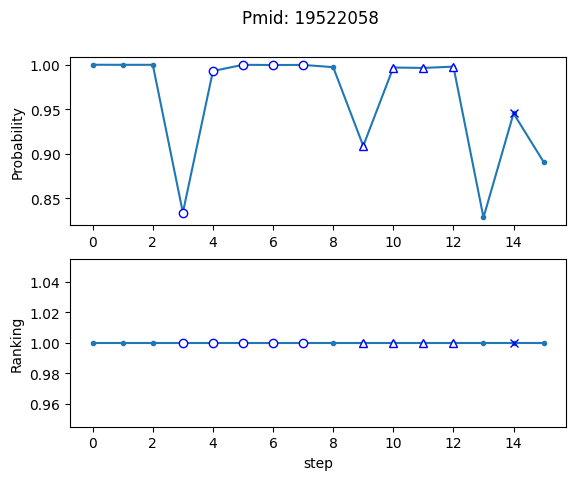

In [144]:
import numpy as np
import matplotlib.pyplot as plt

# Create some fake data.
x = np.arange(step)
y1 = prob
y2 = ranking

fig, (ax1, ax2) = plt.subplots(2, 1)
fig.suptitle(f'Pmid: {test_data["pmid"]}')

ax1.plot(x, y1, '.-')
ax1.set_ylabel('Probability')

ax2.plot(x, y2, '.-')
ax2.set_xlabel('step')
ax2.set_ylabel('Ranking')

marks = [0]* (step-1)
mark = False

# 0 for  parttern tokens, 1 for drugs ,2 for targets, 3 for interaction
for i, token in enumerate(output_text):
    if token != 6 and output_text[i-1] == 45:
        marks[i] = 1
        mark = True
        continue
    if token == 8 or token == 21 or token == 4:
        continue
    if token != 6 and output_text[i-1] == 8:
        marks[i] = 2
        mark = True
        continue
    if token != 6 and output_text[i-1] == 21:
        marks[i] = 3
        mark = True
        continue
    if token == 44:
        mark = False
        continue
    if mark:
        marks[i] = marks[i-1]
        

# if marks[x] == 1, then using hollow circle for the plot, if marks[x] == 2, then using hollow triangle for the plot, if marks[x] == 3, then using star for the plot.
for i in range(step-1):
    if marks[i] == 1:
        ax1.plot(x[i], y1[i], marker='o', color='white', markeredgecolor='blue')
        ax2.plot(x[i], y2[i], marker='o', color='white', markeredgecolor='blue')
        if y2[i] > 5:
            ax1.plot(x[i], y1[i], marker='o', color='white', markeredgecolor='red')
            ax2.plot(x[i], y2[i], marker='o', color='white', markeredgecolor='red')

    if marks[i] == 2:
        ax1.plot(x[i], y1[i], marker='^', color='white', markeredgecolor='blue')
        ax2.plot(x[i], y2[i], marker='^', color='white', markeredgecolor='blue')
        if y2[i] > 5:
            ax1.plot(x[i], y1[i], marker='^', color='red')
            ax2.plot(x[i], y2[i], marker='^', color='red')

    if marks[i] == 3:
        ax1.plot(x[i], y1[i], marker='x', color='white', markeredgecolor='blue')
        ax2.plot(x[i], y2[i], marker='x', color='white', markeredgecolor='blue')
        if y2[i] > 5:
            ax1.plot(x[i], y1[i], marker='x', color='red')
            ax2.plot(x[i], y2[i], marker='x', color='red')


# plt.savefig(f'analysis/img/{test_data["pmid"]}-*.png')
plt.show()